# User models in Sherpa - II

In the previous notebook - [User models in Sherpa](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/user%20model.ipynb) - I showed how you could
write a user model to fit the 
[Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_distribution_function) (CDF) of a data set with a
[Gamma distribution](http://en.wikipedia.org/wiki/Gamma_distribution). Rather than use the
[load_user_model](http://cxc.harvard.edu/sherpa/ahelp/load_user_model.html) function, I showed
how to write the model taking advantage of the Sherpa `Model` class, and the
[add_model](http://cxc.harvard.edu/sherpa/ahelp/add_model.html) function to register the
class with Sherpa.

One question I got from a colleague was why I fit the CDF, rather than the
[Probability Density Function](http://en.wikipedia.org/wiki/Probability_density_function) (PDF)
of the data? Whilst I am not going to answer that question here, I do aim to show how
to fit the PDF, since it:

 - lets me talk about writing models for "integrated" data sets
 - lets me fit the data using a Maximim Likelihood statistic, rather than the
   "least-squares" approach I used previously.

## Follow up

I have a follow-up to this, which is available as
[plotting in Sherpa when using the low-level API](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb). This was written on May 5 2015.

The notebook has since been updated to reflect changes in Sherpa.

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on June 4 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository
if you have any questions.

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2025-10-01 09:35'

In [2]:
import sherpa
sherpa.__version__

'4.18.0.rc1'

## Setting up

First of all I am going to load in the necessary modules, and set up the CDF model I wrote
earlier:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

In [4]:
%matplotlib inline

In [5]:
from sherpa import utils
from sherpa.models import model
from sherpa.models.parameter import tinyval

In [6]:
from sherpa import ui

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


With the imports out of the way, here are routines to calculate the CDF and PDF
of a Gamma distribution:

In [7]:
def calc_gamma_cdf(x, k, theta):
    """Return the CDF of a gamma distribution.

    The cumulative distribution function (CDF) of the gamma
    distribution is defined in [1]_ as::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    Parameters
    ----------
    x : array
       The values at which to evaluate the CDF.
    k : number
       The shape parameter, which must be greater than 0.
    theta : number
       The scale parameter, which must be greater than 0.

    Returns
    -------
    cdf : array
       The CDF evaluated at each element of x.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    # Unfortunately igam does not accept a Numpy array as the
    # second argument, so need to map over the input array.
    #
    tval = theta * 1.0
    kval = k * 1.0
    x = np.asarray(x)
    out = np.zeros_like(x)
    for i,xi in enumerate(x):
        # igam is the "regularized" incomplete gamma (lower)
        # form, so already has the normalization by gamma(a)
        # included.
        out[i] = utils.igam(kval, xi/tval)

    return out

def calc_gamma_pdf(x, k, theta):
    """Return the PDF of a gamma distribution.

    The probability density function (PDF) of the gamma
    distribution is defined in [1]_ as::

       pdf(x;k,theta) = x^(k-1) e^(-x/theta)
                        --------------------
                          gamma(k) theta^k

    Parameters
    ----------
    x : array
       The values at which to evaluate the PDF.
    k : number
       The shape parameter, which must be greater than 0.
    theta : number
       The scale parameter, which must be greater than 0.

    Returns
    -------
    pdf : array
       The PDF evaluated at each element of x.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    tval = theta * 1.0
    kval = k * 1.0
    norm = utils.gamma(kval) * theta**kval
    return x**(kval-1.0) * np.exp(-x / tval) / norm

I am also going to need a routine that integrates the PDF over a range in x. This is just 
the difference in the CDF at the two points, so can be written as:

In [8]:
def calc_gamma_pdf_int(xlo, xhi, k, theta):
    """Return the PDF of a gamma distribution integrated over a bin.

    The probability density function (PDF) of the gamma
    distribution is defined in [1]_ as::

       pdf(x;k,theta) = x^(k-1) e^(-x/theta)
                        --------------------
                          gamma(k) theta^k

    Integrating this gives::

      - theta^k igamma(k, x/theta) + c
      ----------------------------
            gamma(k) theta^k

    where igamma is the incomplete gamma function. Note that this is
    the "upper" form (so int_x^infinity), and sherpa.utils.igam
    calculates the lower-form (which is 1-upper), which is also
    a normalized form, so we get to::

       sherpa.utils.igam(k,xhi/theta) - sherpa.utils.igam(k,xlo/theta)

    which shouldn't be surprising as it's just::

       cdf(xhi;k,theta) - cdf(xlo;k,theta)

    This means that this is just::

       calc_gamma_cdf(xhi,k,t) - calc_gamma_cdf(xlo,k,t)

    Parameters
    ----------
    xlo, xhi : array
       The bin edges over which to integrate the PDF.
    k : number
       The shape parameter, which must be greater than 0.
    theta : number
       The scale parameter, which must be greater than 0.

    Returns
    -------
    pdf : array
       The PDF integrated over xlo to xhi.

    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    return calc_gamma_cdf(xhi, k, theta) - calc_gamma_cdf(xlo, k, theta)

With these, I can write the `GammaCDF` class, which is essentially the same as in the
previous version, *except* that I have now used a finite, but *small*, lower limit on the
`k` and `theta` parameter values, rather than allow them to go down to `0`. The lower limit
is given by `sherpa.models.parameter.tinyval`, which is:

In [9]:
tinyval

1.1754943508222875e-38

In [10]:
class GammaCDF(model.ArithmeticModel):
    """A Gamma CDF.

    The cumulative distribution function (CDF) for the Gamma
    distribution, as defined by [1]_, is::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    The model parameters are:

    k
       The shape parameter, which must be greater than 0.

    theta
       The scale parameter, which must be greater than 0.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
    
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    ndim = 1
    
    def __init__(self, name='gammacdf'):
        self.k = model.Parameter(name, 'k', 5, min=tinyval, hard_min=0)
        self.theta = model.Parameter(name, 'theta', 2, min=tinyval, hard_min=0)

        model.ArithmeticModel.__init__(self, name, (self.k, self.theta))

    @model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta) = pars
        if len(args) == 1:
            x = (x + args[0]) / 2.0

        return calc_gamma_cdf(x, k, theta)

The above model expects either one or two `x` arrays - the independent variable value - which are the location at which to evaluate the model (one array), or the low and high edges of each bin, over which the model should be evaluated. In the CDF case I just use the mid-point of the bin; that is I do not "integrate" the model. However, for the PDF case, where the data is "integrated" - i.e. it represents the number of events within the range, we can integrate up the data. The overall form of the `GammaPDF` class is very similar to `GammaCDF`, but

 - an extra parameter is needed (the number of events),
 - the handling of the model evaluation is slightly different,
 - and a `guess` routine is added so that the normalisation can be set based on the data,

as shown below:

In [11]:
class GammaPDF(model.ArithmeticModel):
    """A Gamma PDF.

    The probability density function (PDF) for the Gamma
    distribution, as defined by [1]_, is::

       pdf(x;k,theta) = x^(k-1) e^(-x/theta)
                        --------------------
                          gamma(k) theta^k

    The model parameters are:

    k
       The shape parameter, which must be greater than 0.

    theta
       The scale parameter, which must be greater than 0.

    norm
       Normalization. The soft minimum is set to 0, but the
       hard_min is left at the default value, so the minimum
       can be made negative if the user wants.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.

    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    ndim = 1
    
    def __init__(self, name='gammapdf'):
        self.k = model.Parameter(name, 'k', 5, min=tinyval, hard_min=0)
        self.theta = model.Parameter(name, 'theta', 2, min=tinyval, hard_min=0)
        self.norm = model.Parameter(name, 'norm', 1, min=0) # allow -ve if they realy want it
        
        model.ArithmeticModel.__init__(self, name, (self.k, self.theta, self.norm))

    @model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta, norm) = pars
        if len(args) == 0:
            return norm * calc_gamma_pdf(x, k, theta)
        elif len(args) == 1:
            # note: this could be a 2D dataset
            return norm * calc_gamma_pdf_int(x, args[0], k, theta)
        else:
            raise ValueError("Expected x or xlo/xhi grid.")
            
    def guess(self, dep, *args, **kwargs):
        """Set the norm parameter based on the data.
        
        The norm parameter is set to be the sum of the dependent axis
        and frozen. The ``k`` and ``theta`` parameters are not changed.
        
        Notes
        -----
        The mean of the values equals k * theta and the mode is
        (k-1) * theta - when k > 1 - so these could be used to set
        k and theta, but I am not convinced it is worth the effort.
        
        """
        norm = dep.sum()
        self.norm.val = dep.sum()
        self.norm.frozen = True

These models can now be added to Sherpa:

In [12]:
ui.add_model(GammaCDF)
ui.add_model(GammaPDF)

Let's set up the same data as used in the previous notebook:

In [13]:
rng = np.random.default_rng(1)

In [14]:
k_orig = 1.1
theta_orig = 2.6
ysim = stats.gamma.rvs(a=k_orig, scale=theta_orig, size=1000, random_state=rng)

## Repeating the CDF fit

First I am going to repeat the CDF fit:

In [15]:
xcdf = ysim.copy()
xcdf.sort()
ycdf = np.arange(1, xcdf.size+1) * 1.0 / xcdf.size

In [16]:
ui.load_arrays('cdf', xcdf, ycdf)
ui.set_model('cdf', gammacdf.cdf)
ui.set_stat('leastsq')
ui.fit('cdf')

Dataset               = cdf
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 238.936
Final fit statistic   = 0.0284038 at function evaluation 26
Data points           = 1000
Degrees of freedom    = 998
Change in statistic   = 238.907
   cdf.k          1.12593      +/- 0.33594     
   cdf.theta      2.53022      +/- 0.997753    


## Fitting with the PDF model

Now I can try the PDF model, which requires binning `ysim` up. I am going to arbitrarily
choose 31 equal-width bins and ensure that it's not actually the PDF that we fit, but the
PDF times the number of events (so that I can use a Maximum-Likelihood statistic for the fit):

In [17]:
(ypdf, edges) = np.histogram(ysim, bins=31, density=False)
xlo = edges[:-1]
xhi = edges[1:]

This time the data is labelled as an "integrated" data set - that is, it is of type
`ui.Data1DInt` rather than `ui.Data1D`, which is the default. This means that the columns refer to the low and high edges of the independent axis, and then the dependent axis values. Since I have integer values, I can use the "Cash" statistic - from
[Parameter estimation in astronomy through application of
the likelihood ratio](http://adsabs.harvard.edu/abs/1979ApJ...228..939C) - which is a Maximum-Likelihood statistic where the data values are assumed to follow a Poisson distribution. I have
seen cases where the default optimiser - the Levenberg-Marquardt method - does not work well
with the Cash statistic (normally when the normalisation of the model is very-far away from the data, which is not an issue for the "pdf" data set, but is for the "check" data set I try later), so I chose the Nelder-Mead Simplex algorithm.

In [18]:
ui.load_arrays('pdf', xlo, xhi, ypdf, ui.Data1DInt)
ui.set_stat('cash')
ui.set_method('neldermead')

When plotted, data bars are added. These values are *not* used in the fit, and are only to help visualize the data:

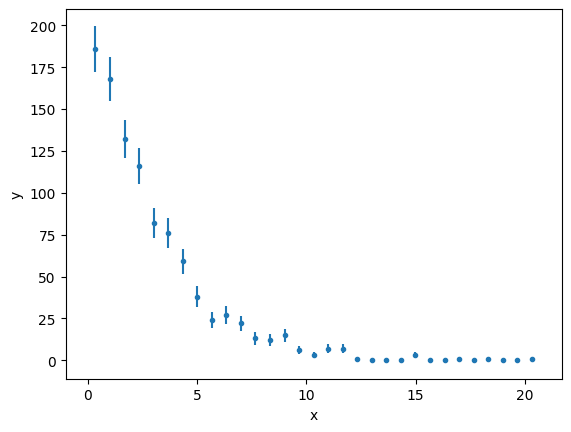

In [19]:
ui.plot_data('pdf')

Here I create an instance of the `GammaPDF` class - using the `gammapdf` function created by
the `add_model` call - called `pdf`:

In [20]:
ui.set_source('pdf', gammapdf.pdf)
pdf

<GammaPDF model instance 'gammapdf.pdf'>

As I went to the effort of writing a `guess` method for this class, let's see what it does:

In [21]:
ui.guess('pdf', pdf)
pdf

<GammaPDF model instance 'gammapdf.pdf'>

The `norm` parameter is now set to the sum of the data - in this 1000 - and has been frozen,
so that it is not varied during the fit.

In [22]:
ui.fit('pdf')

Dataset               = pdf
Method                = neldermead
Statistic             = cash
Initial fit statistic = -139.551
Final fit statistic   = -6922.65 at function evaluation 221
Data points           = 31
Degrees of freedom    = 29
Change in statistic   = 6783.1
   pdf.k          1.11627     
   pdf.theta      2.55127     


The fit is in the right area of parameter space (the input `k` and `theta` values are
1.1 and 2.6), and the fit looks reasonable (note that, as of Sherpa 4.12.2, the model is plotted as a "histogram" for `Data1DInt` data, and from 4.16.1 the residuals also use a "histogram" style here):

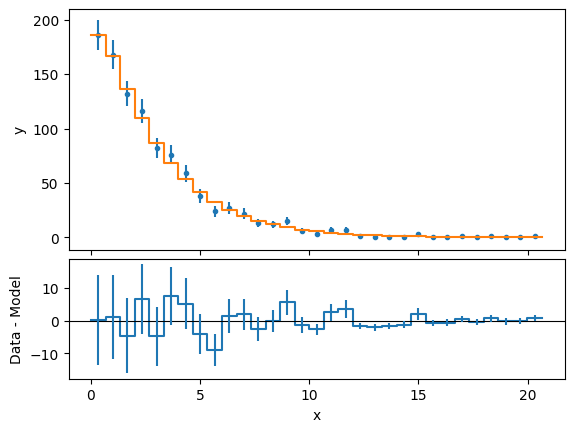

In [23]:
ui.plot_fit_resid('pdf')

Since the Y values cover more than one order of magnitude, let's use a log scale to check (the residual plot refuses to use a logarithmic scale for the Y axis):

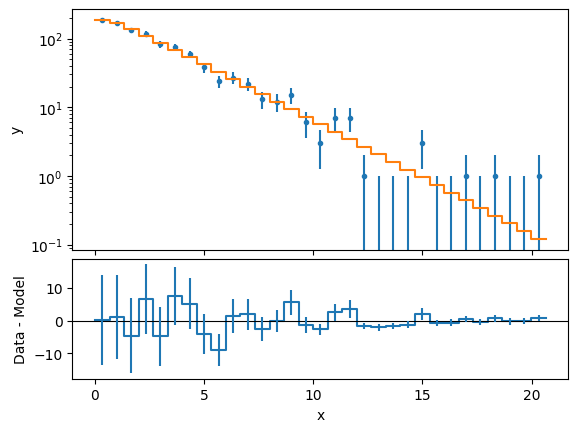

In [24]:
ui.plot_fit_resid('pdf', ylog=True)

One point of fitting the PDF was to see what the errors on the parameters are (note that due to some oddity of the IPython notebook the "lower" and "upper" bound messages, which are displayed as the fit runs, and should appear before the table, are in fact displayed last here):

In [25]:
ui.conf('pdf')

pdf.theta lower bound:	-0.139882
pdf.k lower bound:	-0.053818
pdf.theta upper bound:	0.152128
pdf.k upper bound:	0.055068
Dataset               = pdf
Confidence Method     = confidence
Fitting Method        = neldermead
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pdf.k             1.11627    -0.053818     0.055068
   pdf.theta         2.55127    -0.139882     0.152128


As well as the individual errors, let's look at how they are correlated (the contours
give the one, two, and three sigma ranges, and the cross is the best-fit location). I have
increased the number of points used in this plot since the evaluation is quick (as there
are no free parameters beyond ``k`` and ``theta``).

I'll repeat this plot later on, adding on the actual values and the results from the CDF.

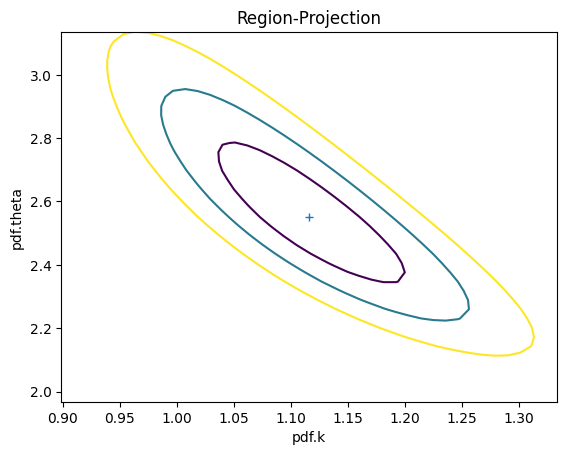

In [26]:
ui.reg_proj(pdf.k, pdf.theta, id='pdf', nloop=[41,41])

## Trying out the "non-integrated" case

The `GammaPDF` model was written to work with both integrated and non-integrated data, so let's see what happens when the latter is used. In this case, I use the same y values but place them at the mid-point of each bin:

In [27]:
ui.load_arrays('check', (xlo+xhi)/2, ypdf)
ui.set_source('check', gammapdf.pdf2)
ui.fit('check')

Dataset               = check
Method                = neldermead
Statistic             = cash
Initial fit statistic = 11348.9
Final fit statistic   = -6922.62 at function evaluation 613
Data points           = 31
Degrees of freedom    = 28
Change in statistic   = 18271.6
   pdf2.k         1.13434     
   pdf2.theta     2.52724     
   pdf2.norm      664.083     


So, the results aren't too different - apart from the fact that the normalisation is lower than the "expected" value of 1000 (as I'm approximating a binned distribution with an un-binned one I wanted to see what happened to the `norm` parameter, which is why I did not fix it).

The fit looks reasonable (but again, remember that the error bars should not be taken too seriously):

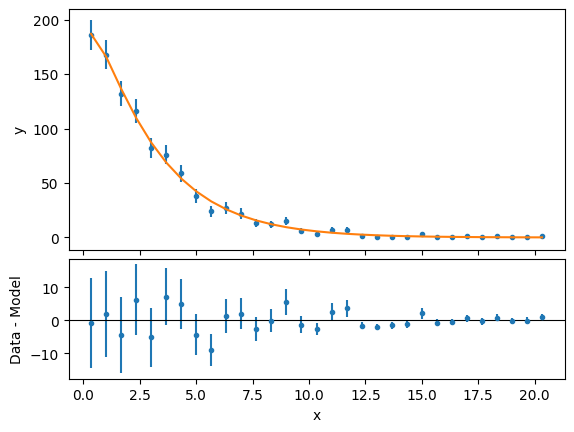

In [28]:
ui.plot_fit_resid('check')

How about the errors?

In [29]:
ui.conf('check')

pdf2.theta lower bound:	-0.145103
pdf2.norm lower bound:	-20.8802
pdf2.k lower bound:	-0.0613981
pdf2.theta upper bound:	0.159716
pdf2.norm upper bound:	21.3042
pdf2.k upper bound:	0.0626481
Dataset               = check
Confidence Method     = confidence
Fitting Method        = neldermead
Statistic             = cash
confidence 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   pdf2.k            1.13434   -0.0613981    0.0626481
   pdf2.theta        2.52724    -0.145103     0.159716
   pdf2.norm         664.083     -20.8802      21.3042


I could try fixing the normalization - to 1000 - and fitting again, but this is enough of
a digression.

## Comparing the answers

The point of this notebook is to give examples of how to write a user model in Sherpa, not
what the best way to fit a Gamma distribution is, but let's just compare the results. I start
with the region-projection plot shown earlier (Sherpa has cached the results for us so we do not need to recalculate it). Then I add on horizontal and vertical lines to show the true
values (i.e. the `k_orig` and `theta_orig` values), and then two green points:

 - the filled circle shows the fit to the CDF
 - the filled triangle shows the fit to the "unbinned" PDF (i.e. the "check" data set)

As can be seen, all values are within the one-sigma contour of the PDF fit, but the
CDF result - which has no error associated with it - is actually closer to the expected value. Now, this is only one data set, so if you really want to investigate this you would have to run a large number of simulations. However, that would be the topic for another post!

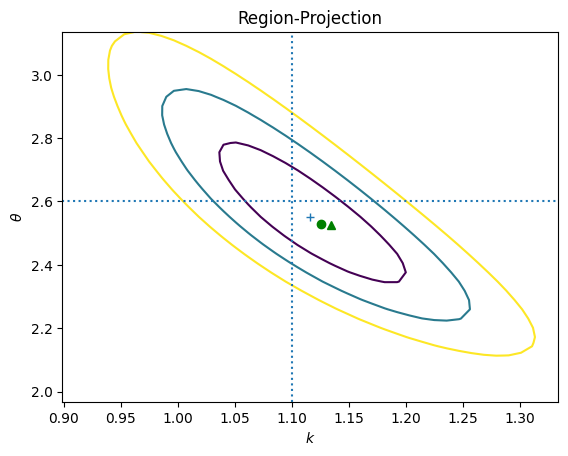

In [30]:
rplot = ui.get_reg_proj()
rplot.contour()
plt.xlabel('$k$')
plt.ylabel('$\\theta$')

xr = plt.xlim()
yr = plt.ylim()
plt.vlines(k_orig, yr[0], yr[1], linestyles='dotted')
plt.hlines(theta_orig, xr[0], xr[1], linestyles='dotted')

plt.plot(cdf.k.val, cdf.theta.val, 'go')
plt.plot(pdf2.k.val, pdf2.theta.val, 'g^');